Here we will compare the inference time of the models trained in the CamVid notebook on a regular CPU. For that purposw we will perform inference on the test set.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Import

In [2]:
!pip install -U albumentations>=0.3.0 --user
!pip install -U --pre segmentation-models --user

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [3]:
import sys
sys.path.append('/root/.local/lib/python3.10/site-packages')
import os
os.environ['SM_FRAMEWORK']='tf.keras'
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Setup

###Utils

In [5]:
# Get trainig parameters to train models

def getTrainingParameters():
  # Loss
  focal_loss = sm.losses.BinaryFocalLoss()
  dice_loss = sm.losses.DiceLoss()
  total_loss = dice_loss + (1 * focal_loss)

  # Metrics
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  # Optimizer
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)

  return total_loss, metrics, optimizer

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def plot_training_curves(history):
    """
    Plots the training and validation curves for loss, IoU score, and F1-score from a Keras History object.

    Parameters:
    history (History): The History object returned by the fit method of a Keras model.
    """

    # Extract training and validation loss values
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Extract training and validation IoU score values
    iou_score = history.history['iou_score']
    val_iou_score = history.history['val_iou_score']

    # Extract training and validation F1-score values
    f1_score = history.history['f1-score']
    val_f1_score = history.history['val_f1-score']

    # Get the number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation IoU score
    plt.subplot(1, 3, 2)
    plt.plot(epochs, iou_score, 'bo-', label='Training IoU Score')
    plt.plot(epochs, val_iou_score, 'ro-', label='Validation IoU Score')
    plt.title('Training and Validation IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()

    # Plot training and validation F1-score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1_score, 'bo-', label='Training F1-Score')
    plt.plot(epochs, val_f1_score, 'ro-', label='Validation F1-Score')
    plt.title('Training and Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_colormap(image, gt_mask, pr_mask, num_classes):
    """Plot image and masks with a colormap."""
    colormap = ListedColormap(plt.cm.get_cmap('tab10').colors[:num_classes])

    # Combine masks into a single image using the class index with the highest probability
    gt_combined = np.argmax(gt_mask, axis=-1)
    pr_combined = np.argmax(pr_mask, axis=-1)

    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Image')
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Ground Truth Mask')
    plt.imshow(gt_combined, cmap=colormap, vmin=0, vmax=num_classes-1)

    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Mask')
    plt.imshow(pr_combined, cmap=colormap, vmin=0, vmax=num_classes-1)

    plt.show()

###Download dataset
CamVid Image Segmentation dataset. 360x480 RGB street scenes images.

In [6]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [7]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

### Dataset definition

In [8]:
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
               'tree', 'signsymbol', 'fence', 'car',
               'pedestrian', 'bicyclist', 'unlabelled']

    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


####Data Loader

In [9]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

###Augmentation and preprocessing

In [10]:
import albumentations as A

In [11]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(heigth=320, width=320):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=heigth, min_width=width, always_apply=True, border_mode=0),
        A.RandomCrop(height=heigth, width=width, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_PSP_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(min_height=384, min_width=384),
        A.CenterCrop(384, 384)
    ]
    return A.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

##Inference time evaluation

####Loading model

In [15]:
CLASSES = ['sky', 'road', 'pavement', 'car',
               'pedestrian', 'bicyclist']
num_classes = len(CLASSES) + 1

In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Weights/end_to_end'

/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid/Weights/end_to_end


In [ ]:
densenet_unet = sm.Unet('densenet121', classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
loss, metrics, optimizer = getTrainingParameters()
densenet_unet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
densenet_unet.load_weights('./Unet/densenet121_unet.h5')


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
resnet101_unet = sm.Unet('resnet101', classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
loss, metrics, optimizer = getTrainingParameters()
resnet101_unet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
resnet101_unet.load_weights('./Unet/resnet101_unet.h5')

171164896/171164896 [==============================] - 1s 0us/step


In [ ]:
densnet_psp = sm.PSPNet('densenet121', classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
loss, metrics, optimizer = getTrainingParameters()
densnet_psp.compile(optimizer=optimizer, loss=loss, metrics=metrics)
densnet_psp.load_weights('./PSPnet/densenet121_pspnet.h5')

In [ ]:
resnet101_psp = sm.PSPNet('resnet101', classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
loss, metrics, optimizer = getTrainingParameters()
resnet101_psp.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
densnet_fpn = sm.FPN('densenet121', classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
loss, metrics, optimizer = getTrainingParameters()
densnet_fpn.compile(optimizer=optimizer, loss=loss, metrics=metrics)
densnet_fpn.load_weights('./FPNnet/densenet121_fpnet.h5')

In [ ]:
resnet_fpn = sm.FPN('resnet101', classes=num_classes, activation='softmax',
                  encoder_weights='imagenet')
loss, metrics, optimizer = getTrainingParameters()
resnet_fpn.compile(optimizer=optimizer, loss=loss, metrics=metrics)
resnet_fpn.load_weights('./FPNnet/resnet101_fpnet.h5')

####Inference

In [ ]:
cd '/content'

/content


In [ ]:
import time

In [ ]:
models = [densenet_unet, resnet101_unet, densnet_fpn, resnet_fpn, densnet_psp, resnet101_psp]
names = ['UNET_densenet121', 'UNET_resnset101', 'FPN_densenet121', 'FPN_resnset101', 'PSP_densenet121', 'PSP_resnset101']

data = []
for i, model in enumerate(models):
  if names[i] == 'PSP_densenet121' or names[i] == 'PSP_resnset101':
      test_dataset = Dataset(
        x_test_dir,
        y_test_dir,
        classes=CLASSES,
        augmentation=get_PSP_validation_augmentation()
    )
  else:
      test_dataset = Dataset(
        x_test_dir,
        y_test_dir,
        classes=CLASSES,
        augmentation=get_validation_augmentation())

  test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

  start = time.time()
  model.evaluate_generator(test_dataloader)
  end = time.time()
  data.append({'model': names[i],
               'time': end-start})

<ipython-input-41-6fbe7d42825f>:23: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_dataloader)


In [ ]:
import pandas as pd
pd.DataFrame(data).to_csv('inference_times.csv')

In [ ]:
data

[{'model': 'UNET_densenet121', 'time': 9.195814609527588},
 {'model': 'UNET_resnset101', 'time': 9.770984649658203},
 {'model': 'FPN_densenet121', 'time': 649.7671723365784},
 {'model': 'FPN_resnset101', 'time': 802.0140643119812},
 {'model': 'PSP_densenet121', 'time': 142.01603865623474},
 {'model': 'PSP_resnset101', 'time': 95.97137546539307}]

####DenseASPP

In [12]:
cd '/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid'

/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid


In [13]:
from My_DenseASPP import FullModel

In [16]:
model = FullModel(num_classes)
loss, metrics, optimizer = getTrainingParameters()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

29084464/29084464 [==============================] - 0s 0us/step


In [19]:
cd '/content'

/content


In [21]:
import time

test_dataset = Dataset(
        x_test_dir,
        y_test_dir,
        classes=CLASSES,
        augmentation=get_PSP_validation_augmentation()
    )
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

start = time.time()
model.evaluate_generator(test_dataloader)
end = time.time()

<ipython-input-21-cf68b191d8e0>:12: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_dataloader)


In [22]:
cd '/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid'

/content/drive/MyDrive/Colab Notebooks/Vision project/Segmentation on CamVid


In [23]:
import pandas as pd

inference_times = pd.read_csv('inference_times.csv', index_col=0)

In [29]:
new_row = {'model': ['dense_aspp'],
           'time': [end-start]}
new_row = pd.DataFrame(new_row)
inference_times = pd.concat([inference_times, new_row], ignore_index=True)

,model,time
0,UNET_densenet121,9.195815
1,UNET_resnset101,9.770985
2,FPN_densenet121,649.767172
3,FPN_resnset101,802.014064
4,PSP_densenet121,142.016039
5,PSP_resnset101,95.971375
6,dense_aspp,206.337421


In [30]:
inference_times['time'] = inference_times['time'] / 60

print(inference_times)

              model       time
0  UNET_densenet121   0.153264
1   UNET_resnset101   0.162850
2   FPN_densenet121  10.829453
3    FPN_resnset101  13.366901
4   PSP_densenet121   2.366934
5    PSP_resnset101   1.599523
6        dense_aspp   3.438957


In [36]:
inference_times.to_csv('inference_times.csv')

####Plot

<ipython-input-39-2d0404a3f1e1>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




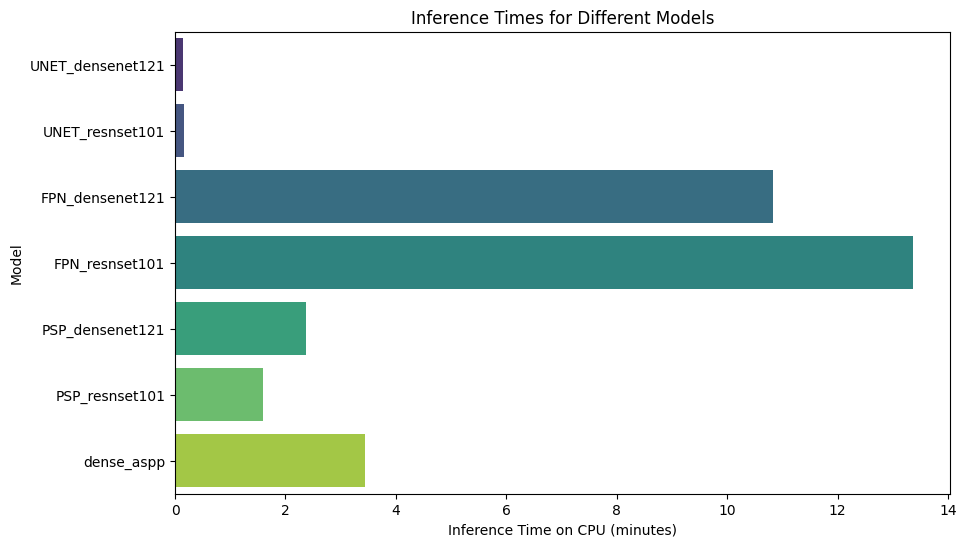

In [39]:
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='time', y='model', data=inference_times, palette='viridis')
plt.xlabel('Inference Time on CPU (minutes)')
plt.ylabel('Model')
plt.title('Inference Times for Different Models')
plt.show()

In [37]:
import plotly.express as px

# Plotting
fig = px.scatter(inference_times, x='model', y='time', size='time', color='model',
                 labels={'time': 'Inference Time (minutes)'},
                 title='Inference Times for Different Models')
fig.show()